# ML modeling

Prior featurization in the data engineering pipeline creates a main dataset with a unique on student id (registered AML). This notebook is intended to be run on AML and train ML model(s) for PowerBI and RAI dashboard consumption.   

### Steps 

1. **Preprocessing data features and labels** 
- basic preprocessing including missing values and categorical variables
- label definition: valid values in Vulnerability column as nominated students (class 1) and missing values as not nominated (class 0) 
- Create proxy labels based on medical features based on expert opinion

2. **Training and evaluating models**

- use 80-20 train-test split on the entire data set
- compute k-fold cross-validation performance with undersampling technique applied on training set 
- build a set of supervised learning models for benchmarking
- additional diagnostics (e.g. compare resampling strategies for imbalanced label, and fairness mitigation) 
 
3. **Register model and data on AML for dashboard consumption**
- user specifies a model name to examine on dashboards
- for PowerBI dashboard, all of the predicted data of a model will be registered; and
- for RAI dashboard, a sklearn model and a sample (up to 5000 rows) of the predicted data will be registered.

In [10]:
# make sure you run this notebook on azureml_py38 conda environment (aka Python 3.8 - AzureML - one of the default conda environments on AML compute instances)
# uncomment this line and install these dependencies if you are running this notebook for the first time
#!pip install protobuf==3.20.1 scikit-learn==1.2.0 imbalanced-learn==0.9.1 fairlearn==0.8.0 fasttreeshap shap

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import textwrap
import time
import toml
from functools import partial
from collections import OrderedDict
from datetime import datetime
import pandas as pd
pd.set_option("display.max_colwidth", 128)
pd.set_option("display.max_rows", 500)

import numpy as np
from scipy.stats import loguniform, uniform
import lightgbm
from lightgbm import LGBMClassifier
from IPython.display import display
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression as skLogit, LogisticRegressionCV as skLogitCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import imblearn
from imblearn.pipeline import Pipeline as pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import interpret
from interpret.glassbox import ExplainableBoostingClassifier
import fasttreeshap
import shap
import fairlearn
from fairlearn.metrics import (
    MetricFrame, plot_model_comparison,
    selection_rate, mean_prediction, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate, true_positive_rate, true_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference, equalized_odds_ratio,
    equalized_odds_difference, count)
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate

import mlflow
from azureml.core import Workspace, Datastore, Dataset


In [12]:
for pkg in [shap, fairlearn, interpret, sklearn, imblearn, pd, np]:
    print(pkg.__version__)

0.41.0
0.8.0
0.2.7
1.2.0
0.9.1
1.1.5
1.21.6


# Load Dataset

Load the main dataset registered on AML by Synapse pipeline (output of data engineering)

In [13]:
from azureml.core import Workspace, Dataset

workspace = Workspace.from_config()

dataset = Dataset.get_by_name(workspace, name="dataset-MainData")
df = dataset.to_pandas_dataframe()

## Preprocess dataset for training ML models


### Basic feature preprocessing including missing values and categorical variables
- validate feature columns (there will be mix of categorical and numeric features)
- categorize features for ease of understanding
- drop year 12 students since we are uncertain why they have no labels (hence the model should not be used to predict on these students)
- drop avg_presentStreak and avg_absentStreak which correlates more than 90% with their min or max versions (average estimates are sensitive to outliers).  
- deduplicate data by student id
- convert features that should be int but casted as strings or floats
- fill missing values from medical features
- check if there is no missing value in features


### Label definition
- valid values in Vulnerability column as nominated students (class 1) and missing values as not nominated (class 0) 


In [14]:
# constants already in dataframe
STUDENT_ID = "StudentDwRefId_pseudonym"
BINARY_TARGET = "Vulnerability"
MULTICLASS_TARGET = "LevelofNeed"
SCHOOL_ID =  "StudentSchoolEnrolmentDwRefId_pseudonym" # provided school info table is used
TIME_STAMP = "TimeStamp"

# new constants 
NOMINATION_TARGET = "Nomination"
PROXY_TARGET = f"Proxy{BINARY_TARGET}"
PROXY_NOMINATION_TARGET = f"Proxy{NOMINATION_TARGET}"
SENSITIVE_COLUMNS = ["EconomicDisadvantageSTAS", "Disability"]

# model parameters
SEED = 1
DEFAULT_RNG = np.random.default_rng(SEED) # set seed for random generator
F_SCORE_BETA = 10  # recall is considered F_SCORE_BETA times as important as precision; see documentation on F-beta scores for details  
SHOW = False # show diagnostic plots globally 
UNDERSAMPLE_RATIO = "auto"  # if None, turn off undersampling; otherwise, set value for sampling_strategy parameter in imblearn
OVERSAMPLE_RATIO = None # if None, turn off oversampling; otherwise, set value for sampling_strategy parameter in imblearn
N_RF_SAMPLES_TO_EXPLAIN = 1000  # explaining sklearn random forest is slow; limit datapoints to explain to < 1000 when debugging; Set to None to override 
SEARCH_HP = False # if True, turn on hyperparameter search; update hp_grid parameter in the train_cv function definition if needed

# categorize features
MEDICAL_CONDITION_COLS = df.columns[df.columns.str.contains("cond$", regex=True)].tolist()
MEDICAL_ALERT_COLS = df.columns[df.columns.str.contains("alert$", regex=True)].tolist()
DISCIPLINARY_COLS = df.columns[df.columns.str.contains("^DisciplinarySanction", regex=True)].tolist()
PROTECTION_COLS = df.columns[df.columns.str.contains("^ProtectionOrderCount", regex=True)].tolist()
ATTENDANCE_COLS = ["sum_absentStreak"]

# the version with the "_earliest_" is redundant  
STUDENT_TEST_SCORE_COLS = [
    "ActualScore_latest_ACFEN",
    "CalendarYear_latest_ACFEN",
    "YearLevelCode_latest_ACFEN",
    "ActualScore_latest_ACFMT",
    "CalendarYear_latest_ACFMT",
    "YearLevelCode_latest_ACFMT",
    "ActualScore_KDC",
    "CalendarYear_KDC"
]

DEMOGRAPHIC_COLS = [
    "Gender", 
    "EconomicDisadvantageSTAS", 
    "Disability", 
    "IndigenousStatusInd",
    "IndependentStatusInd",
    "StudentATSIStatusAny_date2019", 
    "StudentInStateCareIndAny_date2019", 
    "ParentsHighestEducationLevel", 
    "ParentsHighestOccupationLevel",
    "BirthMonth", 
    "BirthYear", 
    "CountryOfBirth", 
    "PermanentResident",
    "InternationalStudentType", 
    "LaunchingIntoLearningInd", 
    "StudentHasActiveEduPointEnrolment", 
    "StudentHasActiveTasTafeEnrolment", 
    "StudentTransitionPlanStatusYear10"
]

ACTION_COLS = [
    "Action_cnt_2019", "wasExpulsed_date2019", 
    "suspensionExtensionCount_date2019", "suspensionExtensionTotalDays_date2019", "suspensionCount_date2019", 
    "suspensionTotalDays_date2019", "exclusionCount_date2019", "exclusionTotalDays_date2019"]

OTHER_MEDICAL_COLS = ["Autism", "ECIS", "HearingImpaired", "IQ55_70", "Intellectual", "KinderSupport", "Level1", "Level2", "Medical", "Multiple", "Physical", "Psychiatric", "VisionImpaired"]

# categorize features for ease of interpretation and visualization
FEATURE_MAP = {
    "Medical": MEDICAL_CONDITION_COLS + MEDICAL_ALERT_COLS + OTHER_MEDICAL_COLS,
    "Demographic": DEMOGRAPHIC_COLS + PROTECTION_COLS, 
    "Action": ACTION_COLS + DISCIPLINARY_COLS,
    "Test": STUDENT_TEST_SCORE_COLS,
    "Attendance": ATTENDANCE_COLS
}

MEDICAL_SERIOUSNESS = {"MINOR": 1, "MODERATE": 2, "SERIOUS": 3, "FATAL":4} 
# other values will be fill with 0
NA_CONDITION_VALUE = 0 

MEDICAL_ALERTIND = {"Y": 1, "N":0} 
# other values will be fill with -1
NA_ALERT_VALUE = -1

INT_ENCODE_COLS = MEDICAL_CONDITION_COLS + MEDICAL_ALERT_COLS

ONE_HOT_ENCODE_COLS = [
    "Gender",
    "Disability",
    "LaunchingIntoLearningInd",
    "IndigenousStatusInd",
    "StudentTransitionPlanStatusYear10",
    "StudentHasActiveTasTafeEnrolment",
    "StudentHasActiveEduPointEnrolment",
    "PermanentResident",
    "InternationalStudentType",
    "IndependentStatusInd",
    "EconomicDisadvantageSTAS",
    "CountryOfBirth",
]


In [15]:

def one_hot_encode(df, columns, sensitive_columns=None):
    if not columns:
        return 
    print("One-hot encoding these columns:", columns)
    if not sensitive_columns:
        sensitive_columns = []
    
    one_hot_map = {}
    one_hot_dummies = []
    for col in columns:
        if df[col].dtypes != "object":
            print(f"{col} is not a string type. Double-check whether this should Top 5 values:")
            print(df[col].value_counts().head())
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = df.join(dummies)
        dummy_cols = dummies.columns.tolist()
        one_hot_dummies.extend(dummy_cols)  
        one_hot_map[col] = dummy_cols
        if col in sensitive_columns:
            sensitive_columns.extend(dummy_cols)
    df = df.drop(columns, axis=1)
    sensitive_columns = [c for c in sensitive_columns if c not in columns]
    return df, one_hot_map, one_hot_dummies, sensitive_columns


def int_encode(df):
    df[MEDICAL_CONDITION_COLS] = df[MEDICAL_CONDITION_COLS].apply(lambda x: x.map(MEDICAL_SERIOUSNESS)).fillna(NA_CONDITION_VALUE)
    df[MEDICAL_ALERT_COLS] = df[MEDICAL_ALERT_COLS].apply(lambda x: x.map(MEDICAL_ALERTIND)).fillna(NA_ALERT_VALUE)
    print("integer-encoded columns:", MEDICAL_CONDITION_COLS+MEDICAL_ALERT_COLS)
    return df            


def get_encoded_feature_maps(encoded_feature_map, feature_map):
    feature_names = []
    inverse_feature_map = {}
    new_feature_map = {}
    for category, feature_cols in feature_map.items():
        new_feature_cols = []
        for c in feature_cols:
            if c in encoded_feature_map:
                encoded_feature_names = encoded_feature_map[c]
                feature_names.extend(encoded_feature_names)
                new_feature_cols.extend(encoded_feature_names) 
                for encoded in encoded_feature_names:
                    inverse_feature_map[encoded] = category
            else:
                feature_names.append(c)
                new_feature_cols.append(c) 
                inverse_feature_map[c] = category
        new_feature_map[category] = new_feature_cols
    return feature_names, new_feature_map, inverse_feature_map


def convert_categorical_to_int(df, columns, exclude=None):
    if exclude is None:
        exclude = []
    mask_boolean = df.dtypes == bool
    mask_obj = df.dtypes == "object"
    # these float columns should be casted as ints
    mask_float_year = df.columns.str.contains("year", case=False) & (df.dtypes == float)
    mask_float_attendance = df.columns.isin(ATTENDANCE_COLS) & (df.dtypes == float)
    mask_category = mask_obj | mask_boolean | mask_float_year | mask_float_attendance
    categoricals = df.dtypes[mask_category].index.difference([STUDENT_ID]).tolist() 
    print("Attempting to convert categorical strings, booleans, or floats into ints ...")
    for c in categoricals:
        if c in columns and c not in exclude:
            try:
                dtypes = df[c].dtypes
                df[c] = df[c].astype(int)
                print(f"{c} is re-casted from {dtypes} as int")
            except:
                print(f"Did not convert {c} with dtype {dtypes}. Showing top 5 value counts:")
                print(df[c].value_counts().head())
                continue    
            
    return df


FEATURE_NAMES = [c for cols in FEATURE_MAP.values() for c in cols]
 
assert set(FEATURE_NAMES).issubset(set(df.columns)), "There are missing FEATURE_MAP columns from dataframe df!" 

# attempting to convert numerical strings and booleans, and categorical floats into ints efficient training; assuming cardinality is not too large
exclude = MEDICAL_CONDITION_COLS + MEDICAL_ALERT_COLS
df = convert_categorical_to_int(df, columns=FEATURE_NAMES, exclude=exclude)

# fill missing value in medical features
df[MEDICAL_CONDITION_COLS + MEDICAL_ALERT_COLS] = df[MEDICAL_CONDITION_COLS + MEDICAL_ALERT_COLS].fillna("NA") 

# integer-encode columns
df = int_encode(df)

# one-hot encode string columns
df, ONE_HOT_MAP, ONE_HOT_ENCODE_COLS, SENSITIVE_COLUMNS = one_hot_encode(df, columns=ONE_HOT_ENCODE_COLS, sensitive_columns=SENSITIVE_COLUMNS)

# update feature names and maps after encoding features
FEATURE_NAMES, FEATURE_MAP, INVERSE_FEATURE_MAP = get_encoded_feature_maps(encoded_feature_map=ONE_HOT_MAP, feature_map=FEATURE_MAP) 

# deduplicates records by unique keys
df = df.drop_duplicates(STUDENT_ID)

# drop Grade 12 students since not sure why they have no labels
# this warrants separate consideration for this group  
df = df[df["YearLevelCode_current"] != 12]


# sanity check no missing values in features
mask_missing_values = df[FEATURE_NAMES].isnull().any()
missing_value_features = mask_missing_values[mask_missing_values].index
if len(missing_value_features) > 0:
    print("There are missing values in features per below! Double-check if this is intended. If so, then make sure your model handles missing values.")
    print(missing_value_features)
    
# sanity check that class 1 of binary target is defined as level of need 3 and 4 in multi-class target
vul_miss_high_need = df[MULTICLASS_TARGET].isnull().equals(df[BINARY_TARGET].isnull())
assert vul_miss_high_need, f"{BINARY_TARGET} and {MULTICLASS_TARGET} have different missing values!"
vul_eq_high_need = df.loc[df[MULTICLASS_TARGET].notnull(), MULTICLASS_TARGET].isin([3, 4]) == df.loc[df[BINARY_TARGET].notnull(), BINARY_TARGET]
if not vul_eq_high_need.all():
    print(df.loc[(~vul_eq_high_need) & (df[MULTICLASS_TARGET].notnull()), [MULTICLASS_TARGET, BINARY_TARGET]])


# define labels: BINARY_TARGET is a nullable float (1.0, 0.0 or NaN) for convenience; NOMINATION_TARGET is a boolean indicating assessment status (True or Falsee)
df[NOMINATION_TARGET] = df[BINARY_TARGET].notnull()


print(f"Number of labeled samples: {sum(~df[BINARY_TARGET].isna())}/{len(df[BINARY_TARGET])}")
print(f"Number of unlabeled samples: {sum(df[BINARY_TARGET].isna())}/{len(df[BINARY_TARGET])}")

Attempting to convert categorical strings, booleans, or floats into ints ...
ActualScore_KDC is re-casted from object as int
Did not convert CountryOfBirth with dtype object. Showing top 5 value counts:
1101     434288
0003      54112
Other     15272
7105       2824
2102       2104
Name: CountryOfBirth, dtype: int64
Did not convert Disability with dtype object. Showing top 5 value counts:
N     455912
Y      62112
NA        32
Name: Disability, dtype: int64
Did not convert EconomicDisadvantageSTAS with dtype object. Showing top 5 value counts:
N    338432
Y    179624
Name: EconomicDisadvantageSTAS, dtype: int64
Did not convert Gender with dtype object. Showing top 5 value counts:
M    265248
F    252464
X       216
Z        72
T        48
Name: Gender, dtype: int64
Did not convert IndependentStatusInd with dtype object. Showing top 5 value counts:
N    512872
Y      5184
Name: IndependentStatusInd, dtype: int64
Did not convert IndigenousStatusInd with dtype object. Showing top 5 value 

In [16]:
for category, cols in FEATURE_MAP.items():
    print(f"Feature category - {category}:")
    print(cols)

Feature category - Medical:
['ADHD_cond', 'ALLERG_cond', 'ANAPH_cond', 'ANXIET_cond', 'ARTHRI_cond', 'ASPERG_cond', 'ASTHMA_cond', 'AUTISM_cond', 'BLADDE_cond', 'BLEED_cond', 'BLOOD_cond', 'BOWEL_cond', 'CEREBP_cond', 'CHROM_cond', 'CLEFT_cond', 'COELI_cond', 'CONST_cond', 'CROHN_cond', 'CROUP_cond', 'CYSTI_cond', 'DEPRES_cond', 'DERMAT_cond', 'DEVEL_cond', 'DI_cond', 'DIAB_cond', 'DIET_cond', 'DOCHOS_cond', 'DOWNS_cond', 'DYSLEX_cond', 'EAR_cond', 'EATING_cond', 'ECZEMA_cond', 'EHLERS_cond', 'EPILEP_cond', 'EYE_cond', 'FAINTD_cond', 'FEET_cond', 'GENERA_cond', 'GROM_cond', 'HEADAC_cond', 'HEARIN_cond', 'HEARTM_cond', 'HIP_cond', 'HRTCON_cond', 'HYPERM_cond', 'INTELL_cond', 'JOINT_cond', 'KIDNEY_cond', 'KNEE_cond', 'LUNG_cond', 'MEDICA_cond', 'MEDICN_cond', 'MIGR_cond', 'MOTSIC_cond', 'OCD_cond', 'OPPOSI_cond', 'OSGOOD_cond', 'OTHER_cond', 'PERMIS_cond', 'PERTHE_cond', 'PREM_cond', 'SCOL_cond', 'SEIZCO_cond', 'SKIN_cond', 'SLEEP_cond', 'SPEECH_cond', 'THYR_cond', 'TOURET_cond', 'VACC_c

## Create proxy labels
Proxy labels provide a way to add additional labels for nomination and students needing personalized support 

In [17]:
# define proxy labels based on expert opinions: 
# medical condition in serious or fatal categories (coded value 3 or 4)
mask_fatal_or_serious_medical_cond = df[MEDICAL_CONDITION_COLS].isin([3, 4]).any(axis=1)
n_proxy_added = mask_fatal_or_serious_medical_cond.sum()
print(f"distribution of proxy labels among all students: {n_proxy_added} ({n_proxy_added/df.shape[0]:.1%})")
print("distribution of proxy labels among nominated students:\n", df[mask_fatal_or_serious_medical_cond][MULTICLASS_TARGET].value_counts())

# add proxy labels PROXY_TARGET and PROXY_NOMINATION_TARGET
df[PROXY_TARGET] = df[BINARY_TARGET]
df.loc[mask_fatal_or_serious_medical_cond, PROXY_TARGET] = 1
df[PROXY_NOMINATION_TARGET] = df[PROXY_TARGET].notnull()


distribution of proxy labels among all students: 1275 (2.3%)
distribution of proxy labels among nominated students:
 3.0    45
2.0    34
4.0    22
1.0    20
Name: LevelofNeed, dtype: int64


In [18]:
# these column names are modified after one-hot encoding
print(SENSITIVE_COLUMNS)
print(ONE_HOT_ENCODE_COLS)

['Disability_NA', 'Disability_Y', 'EconomicDisadvantageSTAS_Y']
['Gender_M', 'Gender_T', 'Gender_U', 'Gender_X', 'Gender_Z', 'Disability_NA', 'Disability_Y', 'LaunchingIntoLearningInd_NA', 'LaunchingIntoLearningInd_Y', 'IndigenousStatusInd_NON-INDIGENOUS', 'IndigenousStatusInd_UNKNOWN', 'StudentTransitionPlanStatusYear10_INPROGRESS', 'StudentTransitionPlanStatusYear10_Not Started', 'StudentTransitionPlanStatusYear10_PENDINGAPPROVAL', 'StudentTransitionPlanStatusYear10_Started', 'StudentTransitionPlanStatusYear10_Submitted', 'StudentHasActiveTasTafeEnrolment_Y', 'StudentHasActiveEduPointEnrolment_Y', 'PermanentResident_Permanent', 'PermanentResident_Temporary', 'InternationalStudentType_Full Fee Paying', 'InternationalStudentType_National', 'IndependentStatusInd_Y', 'EconomicDisadvantageSTAS_Y', 'CountryOfBirth_1100', 'CountryOfBirth_1101', 'CountryOfBirth_1201', 'CountryOfBirth_2100', 'CountryOfBirth_2102', 'CountryOfBirth_5204', 'CountryOfBirth_6101', 'CountryOfBirth_6203', 'CountryOf

## Modeling
- Perform data balance analysis to choose resampling strategy
- Run supervised learning learning pipeline

In [19]:
# sklearn imbalanced classification metrics
scoring_metrics = ["balanced_accuracy", "fbeta_weighted", "recall_weighted", "precision_weighted", "roc_auc", "accuracy", "fbeta", "recall", "precision", "average_precision"]
# suppress warning when DummyClassifier makes no positive predictions
scoring = OrderedDict()
for s in scoring_metrics:
    # deal with errors when dummy prediction has only one class 
    if s in {"precision_weighted", "precision"}:
        scorer = make_scorer(precision_score, average="weighted" if s == "precision_weighted" else "binary", zero_division=0)
    if s in {"fbeta_weighted", "fbeta"}:
        scorer = make_scorer(fbeta_score, beta=F_SCORE_BETA, average="weighted" if s == "fbeta_weighted" else "binary", zero_division=0)
    else:
        scorer = s
    scoring[s] = scorer


# fairness metrics
fairness_metrics = {
    "selection rate": selection_rate,
    "recall": recall_score,
    "fbeta_score": partial(fbeta_score, beta=F_SCORE_BETA, zero_division=0),
    "true positive rate": true_positive_rate,
    "count": count}


def get_fairness_metrics_df(y_true, y_pred, sensitive_features, show=False):
    # evaluate the performance of model fairness    
    performance = MetricFrame(metrics=fairness_metrics,
                            y_true=y_true,
                            y_pred=y_pred,
                            sensitive_features=sensitive_features)

    if show:
        performance.by_group.plot.bar(
            subplots=True,
            layout=[len(fairness_metrics), 1],
            legend=False,
            figsize=[5, 3 * len(fairness_metrics)],
            title="Fairness metrics"
        )
        plt.tight_layout(rect=(0, 0, 0.9, 0.9))
        plt.show()

    try: 
        result = pd.DataFrame({"difference": performance.difference(),
                            "ratio": performance.ratio(),
                            "group_min": performance.group_min(),
                            "group_max": performance.group_max()}).T
    except Exception as e:
        print("Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...")
        print(e)
        result = pd.DataFrame()
    return result 


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def train_cv(X, y, seed=1, cv=None, search_hp=False, hp_grid=None, n_iter=10, scoring_metric="recall", model_dict=None, greater_is_better=True):
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=seed)    
    
    # set up a default set of models to run 
    if model_dict is None:
        # to illustrate the imbalance problem, establish a dummy baseline
        fixed_args = dict(random_state=seed, n_jobs=-1) 
        model_dict = {
            "Dummy": DummyClassifier(strategy="most_frequent"),
            "Logit": skLogit(penalty="l1", solver="liblinear", random_state=seed),
            "RF": RandomForestClassifier(oob_score=True, **fixed_args),
            "LGBM": LGBMClassifier(verbose=-1, **fixed_args),
            "EBM": ExplainableBoostingClassifier(**fixed_args),
        }

    # some models require early stopping so get a additional validation dataset  
    X_train, X_valid, y_train_binary, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y) 
    # set up default hyper-parameter grid for a set of models and fit parameters for specific models 
    fit_params_dict = {}
    if hp_grid is None:
        hp_grid = {
            "Logit": {"C": [1e-2, 1]},
            "RF": {"n_estimators": [100, 500, 1000], "max_depth": [None, 2, 5]},
            "LGBM": {"n_estimators": [100, 500, 1000], "max_depth": [-1, 2, 5], "learning_rate": loguniform(1e-5, 1e-1)},
            "EBM": {"inner_bags": [0], "max_leaves": [3, 32]},
        }
        # LGBM requires early stopping to avoid overfitting
        fit_params_dict = {
            "LGBM": {"early_stopping_rounds": 20, "eval_set": [(X_valid, y_valid)]}
        }

    
    # store performance results 
    hp_results = {}
    for model_label, model in model_dict.items():
        # require pandas output format to use strings as categorical features in the model args
        pipeline = pipeline_with_sampler([(model_label, model)])
        start = time.time()
        # dummy classifier skips resampling and hp search
        if isinstance(pipeline.steps[-1][1], DummyClassifier):
            result = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_estimator=True, return_train_score=True)
            hp_results[model_label] = [(0, result)]
        else:
            # LGBM requires early stopping to avoid overfitting
            if model_label == "LGBM":
                X_, y_ = X_train, y_train_binary 
            else:
                X_, y_ = X, y
                
            # add resampling methods to pipelines
            if UNDERSAMPLE_RATIO is not None:
                pipeline.steps.insert(0, ("undersampling", RandomUnderSampler(sampling_strategy=UNDERSAMPLE_RATIO, random_state=seed)))
            if OVERSAMPLE_RATIO is not None:
                pipeline.steps.insert(0, ("oversampling", RandomOverSampler(sampling_strategy=OVERSAMPLE_RATIO, random_state=seed)))
           
            param_grid = hp_grid.get(model_label, None)
            param_iterator = ParameterSampler(param_grid, n_iter=n_iter, random_state=seed)
            fit_params = fit_params_dict.get(model_label, None)
            if fit_params:
                fit_params = {f"{pipeline.steps[-1][0]}__{k}": v for k, v in fit_params.items()}

            def cv_helper(pipeline):
                # fit cv  
                result = cross_validate(pipeline, X=X_, y=y_, cv=cv, scoring=scoring, return_estimator=True, return_train_score=True, fit_params=fit_params)
                score = np.mean(result[f"test_{scoring_metric}"])
                # store results
                if model_label not in hp_results:
                    hp_results[model_label] = [(score, result)]
                else:
                    hp_results[model_label].append((score, result))
            
            # if search_hp is True, perform search over parameter grid
            if search_hp:
               for idx, param in enumerate(param_iterator):
                    # update model parameter for each hyperparameter set
                    pipeline.steps[-1][1].set_params(**param)
                    cv_helper(pipeline)
            # otherwise, train with default parameters 
            else:
                cv_helper(pipeline)
        model_time = time.time() - start
        print(f"Training {model_label} takes {model_time:.2f} seconds")
        
    # cv_results contains the best hp search results
    cv_results = {model_label: sorted(hp_results[model_label], key=lambda tup: tup[0], reverse=greater_is_better)[0][1] for model_label in model_dict}
    return cv_results


def evaluate_cv(cv_results, X_test, y_test, show=False):
    valid_score_cols = ["test_{}".format(score) for score in scoring]
    valid_scores = pd.DataFrame({k: [v[c].mean() for c in valid_score_cols] for k, v in cv_results.items()}, index=valid_score_cols).T
    valid_scores.columns = valid_scores.columns.str.replace("test_", "")

    # define evaluation set
    test_scores = pd.DataFrame()
    if X_test is not None and y_test is not None:
        test_scores = OrderedDict()
        for model_label, cv_result in cv_results.items():
            cv_test_score = []
            for idx, estimator in enumerate(cv_result["estimator"]):
                y_pred = estimator.predict_proba(X_test)[:, 1]
                score = evaluate(y_test, y_pred, model_label=model_label, show=show)
                cv_test_score.append(score)
            test_scores[model_label] = pd.concat(cv_test_score).mean(0)
        test_scores = pd.DataFrame(test_scores).T
    return valid_scores, test_scores


def evaluate(y_true, y_pred, model_label=None, decision_threshold=0.5, show=SHOW, y_pred_is_proba=True):
    if y_pred_is_proba:
        target_pred = y_pred > decision_threshold
    else:
        target_pred = y_pred
    bac = balanced_accuracy_score(y_true, target_pred)
    precision, recall, fbeta, _ = precision_recall_fscore_support(y_true, target_pred, beta=F_SCORE_BETA, average="weighted", zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred) 
    if show:
        print("Classification report:")
        print(classification_report(y_true, target_pred))
        figure, axes = plt.subplots(1, 3, figsize=(15, 5))
        ConfusionMatrixDisplay.from_predictions(y_true, target_pred, ax=axes[0])
        axes[0].set_title(f"Confusion matrix: {model_label}") 
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=axes[1])
        axes[1].set_title(f"Precision-recall curve: {model_label}")
        RocCurveDisplay.from_predictions(y_true, y_pred, ax=axes[2])
        axes[2].set_title(f"ROC curve: {model_label}")
        plt.tight_layout(rect=(0, 0, 0.9, 0.9))
        plt.show()

    values = [bac, fbeta, recall, precision, roc_auc]
    ac = accuracy_score(y_true, target_pred)
    precision, recall, fbeta, _ = precision_recall_fscore_support(y_true, target_pred, beta=F_SCORE_BETA, average="binary", zero_division=0)
    ap = average_precision_score(y_true, y_pred)
    values += [ac, fbeta, recall, precision, ap]
    scores = dict(zip(list(scoring.keys()), values))
    return pd.DataFrame(scores, index=[0])


wrap_ticks = lambda x: textwrap.fill(x.get_text(), 20)


def plot_balance(label_dist):
    colors = ["grey", "brown", "green", "orange", "red"]
    binary_colors = ["grey", "red"]
    for normalize in [True, False]:

        fig, axes = plt.subplots(2, 1, figsize=(8, 5))
        axes = axes.flat
        for idx, (title, values) in enumerate(label_dist.items()):
            if "need" in title:
                # label un-nominated/un-assessed students
                plot_obj = values.astype("Int64").fillna(-1).value_counts(normalize=normalize).sort_index()
                color = binary_colors
                labels = ["otherwise", "needing personalized support"]
            else:
                # label un-nominated/un-assessed students
                plot_obj = values.astype("Int64").fillna(-1).value_counts(normalize=normalize).sort_index()
                plot_obj.rename(index={-1:"un-nominated"}, inplace=True) 
                color = colors[:] 
                # print(plot_obj)
                labels = plot_obj.index
                if "imputed" in title:
                    color = color[1:]
            measure = ["counts", "proportions"][normalize]
            plot_obj.plot.bar(ax=axes[idx], title=title + f" (train) {measure}" , stacked=True, color=color)
            if normalize:
                axes[idx].set_ylim(0, 1)
            
            axes[idx].set_xticklabels(labels, rotation=0)
        plt.tight_layout()
        plt.show()
    return


def convert_to_shap_interaction_values(main_effects, interaction_effects, interaction_col_delimiter=" x "):
    """
    main_effects: data frame of shape (n_samples, n_features)
    interaction_effects: data frame of shape (n_samples, n_pairwise_interactions)
    N: number of examples
    K: number of features
    """
    n_samples = main_effects.shape[0] 
    n_features = main_effects.shape[1]
    feature_names = main_effects.columns.tolist()
    assert isinstance(main_effects, pd.DataFrame), "main effect must be a data frame with feature names"
    shap_interaction_values = np.zeros((n_samples, n_features, n_features))
    # fill main effects along the diagonal of each example i out of N
    np.einsum("ijj->ij", shap_interaction_values)[...] = main_effects
    error = shap_interaction_values.sum(1).sum(1) - main_effects.sum(1)
    if not interaction_effects.empty:
        # fill interaction effect off the diagonal matrix for pair of interactions
        get_feature_index = lambda x: feature_names.index(x)
        for pair in interaction_effects.columns:
            i, j = map(get_feature_index, pair.split(interaction_col_delimiter))
            # split the interaction effect equally into each order to match SHAP values
            shap_interaction_values[:, i, j] = interaction_effects[pair] * 0.5 
            shap_interaction_values[:, j, i] = interaction_effects[pair] * 0.5
        error -= interaction_effects.sum(1) 
    assert ~np.isnan(error).any(), "there is nan in EBM contr to shap interaction values! Check interaction terms. Possible solution: turn off interaction term."
    if np.max(np.abs(error)) > 1e-6:
        print("there is floating point error in converting EBM contr to shap interaction values!")
    return shap_interaction_values


def get_estimator(pipeline):
    estimator = pipeline
    if hasattr(pipeline, "steps"):
        estimator = pipeline.steps[-1][1]
    return estimator 


def explain(X, cv_results):
    """
    X: features to explain. 
    y: label column. It is optional: if provided, will use X and y to refit a logit model   
    cv_results: a dictionary of the estimators Logit, LGBM, RF, EBM, or all of the above. RF and LGBM explanations use shap implementation of SHAP values.
    index_map: a dataframe that maps from integer index to meaningful index columns such as student ids
    show: controls visualization for feature contributions 
    """
    # explain the drivers for predictions in three models: logit, lgbm, ebm
    # if any one of the conditional models fails, its feature importance vector will be nan 

    contr_dict = {}
    for model_label in cv_results:    
        try: 
            explain_output = None
            model_pipeline = cv_results[model_label]["estimator"][0]
            if model_label == "logit":
                explain_output = explain_logit(X, model_pipeline)
            elif model_label in ["LGBM", "RF", "XGB"]:
                explain_output = explain_tree(X, model_pipeline)
            elif model_label == "EBM":
                explain_output = explain_ebm(X, model_pipeline)

            if explain_output is not None:
                contr_dict[model_label] = explain_output
        except Exception as e:
            print(f"Explaining {model_label} failed for this error:")
            print(e)
    return contr_dict


def explain_logit(X, logit_pipeline):
    # logit explanation
    X_intercept = X.astype(float).copy()
    X_intercept["intercept"] = 1
    logit_model = get_estimator(logit_pipeline)
    coef = pd.Series(np.append(logit_model.coef_, logit_model.intercept_), index=FEATURE_NAMES + ["intercept"])
    logit_contr = X_intercept.multiply(coef)
    logit_pred_proba = add_prediction(logit_model, feature_datasets=[X])
    return (logit_contr, logit_pred_proba)


def explain_tree(X, tree_pipeline):
    # shap explanation
    tree_model = get_estimator(tree_pipeline)
    assert tree_model.classes_[1], "First position of classes must be True!"
    print(f"Generating shap values for {tree_model}. This may take a while ...")
    X_ = X
    if isinstance(tree_model, RandomForestClassifier) and N_RF_SAMPLES_TO_EXPLAIN is not None:
        X_ = X.sample(N_RF_SAMPLES_TO_EXPLAIN, random_state=SEED)
    start = time.time()
    explainer = fasttreeshap.TreeExplainer(tree_model, algorithm="v2", n_jobs=-1, shortcut=False)
    tree_explanations = explainer(X_, check_additivity=False)
    time_spent = time.time() - start
    print(f"Time spent on explaining {tree_model}: {time_spent:.2f} seconds")
    tree_shap_values = tree_explanations.values
    base_values =  tree_explanations.base_values
    if len(tree_shap_values.shape) == 3 and len(base_values.shape) == 2:
        tree_shap_values = tree_shap_values[:, :, 1]
        base_values = base_values[:, 1]
    tree_contr = pd.DataFrame(tree_shap_values, columns=FEATURE_NAMES, index=X_.index)
    tree_contr["intercept"] = base_values
    tree_pred_proba = add_prediction(tree_model, [X_])
    return (tree_contr, tree_pred_proba)   


def explain_ebm(X, ebm_pipeline):
    ebm_model = get_estimator(ebm_pipeline)
    assert ebm_model.classes_[1], "position 1 is not the true label!"
    _, ebm_contr = ebm_model.predict_and_contrib(X)
    ebm_features = ebm_model.feature_names
    interaction_col_delimiter = " x "
    # if ebm_features is None, this is a workaround for breaking change in interpret 0.3.0 
    # see https://github.com/interpretml/interpret/issues/388
    if ebm_features is None:
        ebm_features = ebm_model.term_names_
        interaction_col_delimiter = " & "
    ebm_contr = pd.DataFrame(ebm_contr, columns=ebm_features, index=X.index)
    main_effects = ebm_contr[ebm_features[:X.shape[1]]]
    interaction_effects = ebm_contr[ebm_features[X.shape[1]:]]
    if not interaction_effects.empty: 
        assert interaction_effects.notnull().all().all(), "Found nan in EBM interaction terms, possibly due to EBM\"s inability to handle categorical interaction terms. Try turnning off interaction terms in EBM."
    shap_interaction_values = convert_to_shap_interaction_values(main_effects, interaction_effects, interaction_col_delimiter=interaction_col_delimiter)
    # sum over axis=1 computes total effect of SHAP values
    ebm_contr = pd.DataFrame(shap_interaction_values.sum(axis=1), columns=main_effects.columns, index=X.index)
    ebm_contr["intercept"] = ebm_model.intercept_.item()
    ebm_pred_proba = add_prediction(ebm_model, [X])
    return (ebm_contr, ebm_pred_proba)


def verify_explanations(contr_dict,  num_features_to_examine=5, index_map=None, delta=1e-2, show=SHOW):
    # add index and column information to model contributions; and optionally visualize them 
    explanation_dict = {}
    for model_label, (contr, pred_proba) in contr_dict.items():
        if contr is None: 
            continue
        sum_contr = contr.sum(1).apply(sigmoid)
        if sum_contr.corr(pred_proba) < (1-delta) or (not sum_contr.equals(pred_proba)):
            print(f"{model_label} local accuracy may have precision issues!")
        contr_imp = contr.abs().mean().sort_values(ascending=False).drop("intercept")
        top_k_features = contr_imp.head(num_features_to_examine).index.tolist()

        # add back meaningful index keys for data rows
        if index_map is not None:
            index_columns = index_map.columns.tolist()
            contr = contr.merge(index_map, left_index=True, right_index=True)
            contr = contr.set_index(index_columns)
            
        # add multilevel index to categorize feature importance
        if contr.columns.nlevels == 1:
            inverse_map = {"intercept": "Intercept", **INVERSE_FEATURE_MAP}
            column_formatter = lambda x: inverse_map.get(x, "Interactions")
            categories = contr.columns.map(column_formatter).fillna("Others")
            contr.columns = pd.MultiIndex.from_arrays([categories, contr.columns], names=["Category", "Feature"])
        
        if show:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            ax = axes[0]
            contr_imp[top_k_features].plot.bar(ax=ax, rot=20)
            ax.set_title(f"Average Magnitude of Top {num_features_to_examine} {model_label} Feature Contributions")
            ax.set_ylabel("log-odds")
            ax.set_xticklabels(map(wrap_ticks, ax.get_xticklabels()))
            ax = axes[1]
            agg_contr_imp = contr.groupby(level=0, axis=1).sum().abs().mean().sort_values(ascending=False).drop("Intercept")
            agg_contr_imp.plot.bar(ax=ax, rot=20)
            ax.set_title(f"Average Magnitude of {model_label} Feature Contributions by Categories")
            ax.set_ylabel("log-odds")
            ax.set_xticklabels(map(wrap_ticks, ax.get_xticklabels()))
            plt.tight_layout()
            plt.show()
        
        explanation_dict[model_label] = contr 

    if len(explanation_dict) == 0:
        return pd.DataFrame()
    
    explanations = pd.concat(explanation_dict)
    return explanations
    

def add_prediction(model, feature_datasets):
    predictions = []
    for X in feature_datasets:
        if X is None: continue
        if hasattr(model, "predict_proba"):
            assert model.classes_[1], "class 1 is not the model predicted class!"
            pred = pd.Series(model.predict_proba(X)[:, 1])
        else:
            pred = pd.Series(model.predict(X))
        pred.index = X.index
        predictions.append(pred)
    pred_nominated = pd.concat(predictions)
    return pred_nominated


def define_train_test_set(df, use_balance_sample=True, use_unnominated_only=False, disable_test_set=False, label=BINARY_TARGET):
    
    mask_need = df[label] == 1 # only those which were assessed and needed to be assessed
    mask_unnominated = df[label].isnull()

    if use_balance_sample:
        mask = ~mask_need
        mask_label = "mix of un-nominated and no need for personalized support"
        if use_unnominated_only:
            mask = mask_unnominated
            mask_label = "un-nominated"
        unnominated = df.loc[mask].sample(sum(mask_need), random_state=SEED)
        nominated = df[mask_need]
        dataset_to_use = pd.concat([unnominated, nominated])
        # assume no nomination means no need for personalized support
        dataset_to_use[BINARY_TARGET] = dataset_to_use[BINARY_TARGET].fillna(0)
        print(f"From {df.shape[0]} students, sampled {dataset_to_use.shape[0]} = {unnominated.shape[0]} {mask_label} + {nominated.shape[0]} assessed")
    else:
        # in our new formulations, we define train-test set on the entire dataset including un-nominated students (the majority in this dataset) 
        dataset_to_use = df

    features, labels = dataset_to_use[FEATURE_NAMES], dataset_to_use[label]
    X_train, X_test, y_train_binary, y_test_binary = train_test_split(features, labels, test_size=0.20, random_state=SEED)
    if disable_test_set:
        X_train, X_test, y_train_binary, y_test_binary = features, None, labels, None
        print("Disabled test set. Train data shape:", X_train.shape, f" positive label pct {y_train_binary.mean():.2%}")
    else:
        print(f"Train data shape:", X_train.shape,  f" positive label pct {y_train_binary.mean():.2%}")
        print(f"Validation/test data shape:", X_test.shape,  f" positive label pct {y_test_binary.mean():.2%}")
    return dataset_to_use, X_train, X_test, y_train_binary, y_test_binary


def evaluate_dataset(model_labels, target_label, dataset, data_subset_labels=None):
    if data_subset_labels is None:
        data_subset_labels = ["train", "test"]
    # evaluate nomination predictions against labels 
    model_accuracy_scores = {}
    model_fairness_scores = {}
    for model_label in model_labels:
        start = time.time()
        # evaluate train-test performance on accuracy and fairness
        accuracy_scores = {}
        fairness_scores = {}
        for data_subset_label in data_subset_labels:
            data_subset = dataset.loc[dataset["dataset"] == data_subset_label]
            y_true = data_subset[target_label]
            y_pred = data_subset[f"{target_label}{model_label}Proba"]
            
            # compute accuracy performance metrics
            target_pred = y_pred > 0.5
            perf_label = f"supervised {data_subset_label}\n{model_label}"
            print(f"{perf_label} data has {y_true.shape[0]} rows with {y_true.sum()} class 1 ({y_true.mean():.2%})")
            score = evaluate(y_true, y_pred, model_label=perf_label)
            accuracy_scores[data_subset_label] = score

            # compute fairness metrics for each sensitive feature
            fairness_by_feature = {}
            # get unmitigated summary
            for sensitive_col in SENSITIVE_COLUMNS:
                fairness_summary = get_fairness_metrics_df(y_true=y_true, y_pred=target_pred, sensitive_features=data_subset[sensitive_col], show=SHOW)
                fairness_by_feature[sensitive_col] = fairness_summary
            fairness_scores[data_subset_label] = pd.concat(fairness_by_feature)
        time_spent = time.time() - start
        print(f"Evaluating {model_label} on accuracy and fairness takes {time_spent:.2f} seconds")
        model_accuracy_scores[model_label] = pd.concat(accuracy_scores).reset_index(level=-1, drop=True)
        model_fairness_scores[model_label] = pd.concat(fairness_scores)

    model_accuracy_scores = pd.concat(model_accuracy_scores)
    model_fairness_scores = pd.concat(model_fairness_scores)
    
    return model_accuracy_scores, model_fairness_scores


def run_basic_pipeline(df, model_dict=None, use_balance_sample=True, use_unnominated_only=False, label=BINARY_TARGET, disable_test_set=False, seed=1):
    """
    a pipeline consists of
        - plot label balance  
        - train predictive models
        - print validation and test performance metrics
        - plot global explanations
    method: str that indicates a methodology 
    label: the target columns to predict
    seed: the random seed to control train-test split
    return: a tuple of a model object (or a list of them) and a pandas DataFrame with a column predicting the target
    """
    # store results in a dictionary
    results = {}

    # define train/test feature/label dataset
    dataset_to_use, X_train, X_test, y_train_binary, y_test_binary = define_train_test_set(
        df=df, use_balance_sample=use_balance_sample, use_unnominated_only=use_unnominated_only, label=label, disable_test_set=disable_test_set)

    # plot label distribution
    label_dist = {
        f"{MULTICLASS_TARGET} distribution": dataset_to_use[MULTICLASS_TARGET],
        f"{label} label distribution": y_train_binary, 
    }
    if SHOW:
        plot_balance(label_dist=label_dist)

    student_need_dist = dataset_to_use[MULTICLASS_TARGET].fillna(-1)
    results["label_distr_pct"] = student_need_dist.value_counts(normalize=True)
    results["label_distr_cnt"] = student_need_dist.value_counts()

    # train a number of models (sklearn pipelines) in cross-validation fashion
    cv_results = train_cv(X_train, y_train_binary, model_dict=model_dict, seed=seed, search_hp=SEARCH_HP)

    # report the validation and test scores 
    valid_scores, test_scores = evaluate_cv(cv_results, X_test, y_test_binary) 
    results["validation_scores"] = valid_scores
    results["test_scores"] = test_scores

    # explain the models
    explanation_dict = explain(dataset_to_use[FEATURE_NAMES], cv_results=cv_results)
    local_explanations = verify_explanations(explanation_dict, num_features_to_examine=5, index_map=dataset_to_use[[STUDENT_ID]])
    
    if not local_explanations.empty:
        global_explanations = local_explanations.droplevel(level=0, axis=1).abs().groupby(level=0, axis=0).mean().T
        imp_cosine_similarity = global_explanations.loc[FEATURE_NAMES].corr(method=lambda x, y: x.dot(y)/(np.linalg.norm(x)*np.linalg.norm(y)))
        imp_cosine_similarity = pd.concat({"Explanation Agreement (Cosine Similarity)": imp_cosine_similarity}, axis=1)
        results["feature_importance"] = local_explanations
        results["explanation_similarity"] = imp_cosine_similarity

    # gather the model results
    for model_label in cv_results:
        model = cv_results[model_label]["estimator"][0] 
        feature_datasets = (X_train, X_test)
        dataset_to_use[f"{label}{model_label}Proba"] = add_prediction(model, feature_datasets=feature_datasets)
    results["predicted_data"] = dataset_to_use
    results["cv_results"] = cv_results
    return results


def run_supervised_learning_on_nomination(df, model_dict=None, use_proxy_label=True, seed=1):
    """train on entire dataset predicting nomination status"""
    pipeline_results = {}
    df = df.copy()
    
    # apply train-test split on the full dataset 
    df[NOMINATION_TARGET] = df[BINARY_TARGET].notnull()
    df[PROXY_NOMINATION_TARGET] = df[PROXY_TARGET].notnull()
    train, test = train_test_split(df, test_size=0.20, random_state=seed)

    # build nomination model and apply predictions
    target_label = PROXY_NOMINATION_TARGET if use_proxy_label else NOMINATION_TARGET
    nomination_results = run_basic_pipeline(df=train, model_dict=model_dict, use_balance_sample=False, disable_test_set=False, label=target_label)
    for model_label, cv_result in nomination_results["cv_results"].items():
        model = cv_result["estimator"][0]
        for temp in [train, test]:
            nomination_pred_label = f"{target_label}{model_label}Proba"
            temp[nomination_pred_label] = add_prediction(model, feature_datasets=[temp[FEATURE_NAMES]])

    # combine train and test set back into the result dataframe
    combined_data = pd.concat([train, test])
    combined_data["dataset"] = combined_data.index.isin(train.index)
    combined_data["dataset"] = combined_data["dataset"].map({True: "train", False:"test"})

    # evaluate marginal need predictions against labels 
    model_labels = list(nomination_results["cv_results"].keys()) 
    model_accuracy_scores, model_fairness_scores = evaluate_dataset(
        model_labels=model_labels, dataset=combined_data, target_label=target_label)

    # explain models
    explanation_dict = explain(combined_data[FEATURE_NAMES], cv_results=nomination_results["cv_results"])
    local_explanations = verify_explanations(explanation_dict, num_features_to_examine=5, index_map=combined_data[[STUDENT_ID]])
    
    pipeline_results["accuracy_scores"] = model_accuracy_scores
    pipeline_results["fairness_scores"] = model_fairness_scores
    pipeline_results["predicted_data"] = combined_data
    pipeline_results["nomination_results"] = nomination_results
    pipeline_results["feature_importance"] = local_explanations
    return pipeline_results

## Resampling analysis
- compare the impact of resampling strategies on results 


In [20]:
from copy import deepcopy


model_label = "RF"
model = RandomForestClassifier(oob_score=True, verbose=0, random_state=SEED)
seed = 1

fold_idx = 0 # pick a model for a random fold in k-fold validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=seed)    
pipeline_labels = ["SQ", "undersample", "oversample+undersample"]

def compare_resampling_strategy(df, target_feature, feature_names=None, train_size=1):
    if feature_names is None:
        feature_names = FEATURE_NAMES
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    if train_size < 1:
        train = train.sample(int(train_size * train.shape[0]), random_state=seed)
    X_train, y_train = train[feature_names], train[target_feature].fillna(0).astype(int)

    pipelines = []
    pipeline = pipeline_with_sampler([(model_label, model)])
    pipelines += [deepcopy(pipeline)]
    pipeline.steps.insert(0, ("undersampling", RandomUnderSampler(sampling_strategy="auto", random_state=seed)))
    pipelines += [deepcopy(pipeline)]
    pipeline.steps.insert(0, ("oversampling", RandomOverSampler(sampling_strategy="auto", random_state=seed)))
    pipelines += [deepcopy(pipeline)]
    
    out =  {}
    for label, pipeline in zip(pipeline_labels, pipelines):
        model_results = cross_validate(pipeline, X=X_train, y=y_train, cv=cv, scoring=scoring, return_estimator=True, return_train_score=True, fit_params=None)
        # fetch training and validation scores on k folds
        train_scores = pd.DataFrame({s: model_results[f"test_{s}"].mean() for s in scoring}, index=[model_label])
        valid_scores = pd.DataFrame({s: model_results[f"test_{s}"].mean() for s in scoring}, index=[model_label])
        print(f"Running resampling strategy: {label}")
        out[label] = pd.concat({"train": train_scores, "valid": valid_scores}).round(2)
    return pd.concat(out)



In [21]:

compare_resampling_strategy(df, target_feature=PROXY_NOMINATION_TARGET)

Running resampling strategy: SQ
Running resampling strategy: undersample
Running resampling strategy: oversample+undersample


balanced_accuracy  fbeta_weighted  \
SQ                     train RF               0.67            0.92   
                       valid RF               0.67            0.92   
undersample            train RF               0.80            0.80   
                       valid RF               0.80            0.80   
oversample+undersample train RF               0.70            0.91   
                       valid RF               0.70            0.91   

                                 recall_weighted  precision_weighted  roc_auc  \
SQ                     train RF             0.92                0.91     0.88   
                       valid RF             0.92                0.91     0.88   
undersample            train RF             0.80                0.90     0.88   
                       valid RF             0.80                0.90     0.88   
oversample+undersample train RF             0.91                0.90     0.88   
                       valid RF             0.91                0.90     0.88   

                                 accuracy  fbeta  recall  precision  \
SQ                     train RF      0.92   0.36    0.36       0.81   
                       valid RF      0.92   0.36    0.36       0.81   
undersample            train RF      0.80   0.80    0.81       0.34   
                       valid RF      0.80   0.80    0.81       0.34   
oversample+undersample train RF      0.91   0.43    0.43       0.67   
                       valid RF      0.91   0.43    0.43       0.67   

                                 average_precision  
SQ                     train RF               0.62  
                       valid RF               0.62  
undersample            train RF               0.53  
                       valid RF               0.53  
oversample+undersample train RF               0.57  
                       valid RF               0.57

The results above suggest recall rate will benefit from training models with oversampling technique, which we use for the following. 

Note that other strategies to mitigate data imbalance are possible, for example:
- using asymmetric cost function in model training objective (by setting higher class weights on minority classes);
- ensembling diverse models on resampled data; or
- treat the problem as anomaly detection if the minority class is very rare.

## Run the supervised learning pipeline

Specify the models you want to run. Depending on your input data and use case, consider:
1. missingness in data and the ability of the model to handle it (e.g. LGBM, XGBoost)
2. efficient or automatic encoding of categorical data (EBM)
3. efficient interpretability with categorical feature support (EBM*, LGBM**)
4. support from RAI dashboard (sklearn estimators only at the moment)

\* EBM support auto-encoding of categorical data type (e.g. "object", "bool", "category").  

\** shap.TreeExplainer supports only computation of shap values but not shap interaction values for LGBM trained on string features. As an alternative, it is also possible to interpret feature contributions from EBM (which fully supports categorical features) as shap interaction values where single feature contributions are the main effects and pairwise feature contributions are non-zero interaction effects.  

The pipeline does the following:

- plot label balance  
- train a set of explanable predictive models with undersampling technique
- evaluate model on validation and test performance metrics
- generate global explanations
- generate fairness metrics
- can set global variable SHOW = True to generate diagnostic plots by data scientists 

In [22]:


# specify seed and turn on CPU parallelism
fixed_args = dict(random_state=SEED, n_jobs=-1) 

# specify model(s) to run; to run RAI dashboard, only sklearn models (e.g. Logit and RF below) are currently supported 
model_dict = {
    "Dummy": DummyClassifier(strategy="most_frequent"), # set a baseline for imbalanced dataset
    "Logit": skLogit(penalty="l1", solver="liblinear", random_state=SEED),  # requires one-hot encoding for categorical features
    "RF": RandomForestClassifier(oob_score=True, **fixed_args), #  requires one-hot encoding for categorical features
    "LGBM": LGBMClassifier(learning_rate=0.01, verbose=-1, **fixed_args),   
    "EBM": ExplainableBoostingClassifier(**fixed_args),
}
proxy_supervised_nomination = run_supervised_learning_on_nomination(df, model_dict=model_dict, use_proxy_label=True, seed=SEED)



Train data shape: (35457, 190)  positive label pct 11.31%
Validation/test data shape: (8865, 190)  positive label pct 11.77%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due t

Training Dummy takes 0.30 seconds


Liblinear failed to converge, increase the number of iterations.


Training Logit takes 11.89 seconds
Training RF takes 4.50 seconds
[1]	valid_0's binary_logloss: 0.68905
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.685058
[3]	valid_0's binary_logloss: 0.68112
[4]	valid_0's binary_logloss: 0.677286
[5]	valid_0's binary_logloss: 0.673526
[6]	valid_0's binary_logloss: 0.669836
[7]	valid_0's binary_logloss: 0.666211
[8]	valid_0's binary_logloss: 0.662638
[9]	valid_0's binary_logloss: 0.659165
[10]	valid_0's binary_logloss: 0.655726
[11]	valid_0's binary_logloss: 0.652369
[12]	valid_0's binary_logloss: 0.649064
[13]	valid_0's binary_logloss: 0.645867
[14]	valid_0's binary_logloss: 0.642641
[15]	valid_0's binary_logloss: 0.639489
[16]	valid_0's binary_logloss: 0.636411
[17]	valid_0's binary_logloss: 0.633353
[18]	valid_0's binary_logloss: 0.630346
[19]	valid_0's binary_logloss: 0.627409
[20]	valid_0's binary_logloss: 0.624523
[21]	valid_0's binary_logloss: 0.621684
[22]	valid_0's binary_logloss: 0.618917
[23]

There may exist memory issue for algorithm v2. Switched to algorithm v1.


Time spent on explaining RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1): 27.61 seconds
Generating shap values for LGBMClassifier(learning_rate=0.01, random_state=1, verbose=-1). This may take a while ...
Time spent on explaining LGBMClassifier(learning_rate=0.01, random_state=1, verbose=-1): 1.88 seconds
there is floating point error in converting EBM contr to shap interaction values!
RF local accuracy may have precision issues!
LGBM local accuracy may have precision issues!
EBM local accuracy may have precision issues!
supervised train
Dummy data has 44322 rows with 5054 class 1 (11.40%)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...
float division by zero
Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...
float division by zero
Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...
float division by zero
supervised test
Dummy data has 11081 rows with 1326 class 1 (11.97%)
Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...
float division by zero
Error occurred in computing fairness parity metrics. This might be normal if this is a dummy classifier predicting only one class. Skipping ...
float division by zero
Error occurred in computing fairness parity metrics. This might be normal if this is a dummy cla

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


supervised test
Logit data has 11081 rows with 1326 class 1 (11.97%)
Evaluating Logit on accuracy and fairness takes 1.56 seconds
supervised train
RF data has 44322 rows with 5054 class 1 (11.40%)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


supervised test
RF data has 11081 rows with 1326 class 1 (11.97%)
Evaluating RF on accuracy and fairness takes 1.42 seconds
supervised train
LGBM data has 44322 rows with 5054 class 1 (11.40%)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


supervised test
LGBM data has 11081 rows with 1326 class 1 (11.97%)
Evaluating LGBM on accuracy and fairness takes 1.40 seconds
supervised train
EBM data has 44322 rows with 5054 class 1 (11.40%)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


supervised test
EBM data has 11081 rows with 1326 class 1 (11.97%)
Evaluating EBM on accuracy and fairness takes 1.45 seconds
Generating shap values for RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1). This may take a while ...


There may exist memory issue for algorithm v2. Switched to algorithm v1.


Time spent on explaining RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1): 27.79 seconds
Generating shap values for LGBMClassifier(learning_rate=0.01, random_state=1, verbose=-1). This may take a while ...
Time spent on explaining LGBMClassifier(learning_rate=0.01, random_state=1, verbose=-1): 2.21 seconds
there is floating point error in converting EBM contr to shap interaction values!
RF local accuracy may have precision issues!
LGBM local accuracy may have precision issues!
EBM local accuracy may have precision issues!


## How to extract supervised learning pipeline outputs
1. model: a ML model object with sklearn-style API  
2. predicted_data: a pandas dataframe with features, labels, predicted labels, pseudonymized student ids, and a column "dataset" with values "train" or "test" indicating dataset type
3. accuracy_scores: a pandas dataframe with accuracy scores on training and test dataset
4. fairness_scores: a pandas dataframe with fairness scores on training and test dataset
5. feature_importance: a pandas dataframe with local feature importance (the same shape as model input) for each data row; and the features may be organized in a hierarchy 

In [23]:
# post-process model outputs
# define functions to add dummy time and school info for downstream PowerBI dashboard consumption 
def add_dummy_school(df, n_schools=10, school_feature=SCHOOL_ID):
    if school_feature not in df:
        dummy_school_values = np.random.choice(n_schools, size=df.shape[0], replace=True)
        df[school_feature] = dummy_school_values
    return df

def add_dummy_time(df, start, end, freq):
    # create the date range for the specified frequency 
    dummy_time_range = pd.date_range(start=start, end=end, freq=freq)
    # assign to each row a random time stamp
    dummy_time_stamps = DEFAULT_RNG.choice(dummy_time_range, replace=True, size=df.shape[0])
    df[TIME_STAMP] = pd.to_datetime(dummy_time_stamps)
    return df

# variables defined
model_label = "RF"
train_features = FEATURE_NAMES
school_feature = SCHOOL_ID
use_proxy_label = True  # add proxy labels or not
target_feature = PROXY_NOMINATION_TARGET if use_proxy_label else NOMINATION_TARGET
predicted_feature = f"{target_feature}{model_label}Proba"

# predicted_data a pandas dataframe with features, labels, predicted labels, pseudonymized student ids, and a column "dataset" with values "train" or "test" indicating dataset type
predicted_data = proxy_supervised_nomination["predicted_data"].copy()


# also add dummy school and time stamp info
predicted_data = add_dummy_school(predicted_data, n_schools=10, school_feature=SCHOOL_ID)
predicted_data = add_dummy_time(predicted_data, start="2018-01-01", end="2023-01-01", freq="Q")  # "Q" for quarterly frequency

#  get training and test dataset (indexed by student id) 
indexed_data = predicted_data.set_index(STUDENT_ID)
train_data = indexed_data[indexed_data["dataset"] == "train"]
test_data = indexed_data[indexed_data["dataset"] == "test"]

# get the dataframe with all columns
available_columns = [STUDENT_ID, target_feature, predicted_feature, "dataset", SCHOOL_ID, TIME_STAMP] + train_features

## Model outputs (pandas dataframes) for PowerBI consumptions 

In [24]:
# PowerBI dashboard 1
# for pie chart target feature distribution (binary variable)
target_dist = predicted_data[target_feature].value_counts(normalize=True).rename("Percentage").rename_axis(target_feature)
# for bar chart with school break-down
target_dist_by_school = predicted_data.groupby(SCHOOL_ID)[target_feature].mean()
# for time-series chart
quarterly_target_mean = predicted_data.groupby([SCHOOL_ID, TIME_STAMP])[target_feature].mean()

# PowerBI dashboard 2 
# feature importance dataframes for a given model
feature_importance = proxy_supervised_nomination["feature_importance"].copy()
feature_importance = feature_importance.loc[pd.IndexSlice[model_label, :], :]
feature_importance.index.names = ["Model", STUDENT_ID]
feature_importance_pivot = feature_importance.unstack(level=0)
# add school index
school_index = feature_importance_pivot.index.map(predicted_data.set_index(STUDENT_ID)[SCHOOL_ID].to_dict())
school_index.name = SCHOOL_ID
feature_importance_pivot.set_index(school_index, append=True, inplace=True)

# find the top k feature to display
top_k_features = 4 
# for the student records where top k features are shown: user can query individual student's ranked features 
feature_importance_magnitude = feature_importance_pivot.stack([0, 1, 2]).rename('Magnitude').abs().reset_index()
top_k_feature_idx = feature_importance_magnitude.groupby([SCHOOL_ID, STUDENT_ID, "Model"])["Magnitude"].nlargest(top_k_features).index.get_level_values(-1)
student_feature_importance = feature_importance_magnitude.loc[top_k_feature_idx]

# for bar chart with average magnitude of the top k important feature contributions
individual_feature_importance =  feature_importance_pivot.unstack(level=-1).apply(lambda x: x.abs().mean(), axis=0).rename("AverageMagnitude")
# (additional) for bar chart with avearge magnitude of the contribution from each category of features
categorical_feature_importance = feature_importance_pivot.unstack(level=-1).groupby(axis=1, level=[0, -2, -1]).sum().apply(lambda x: x.abs().mean(), axis=0).rename("AverageMagnitude")

# PowerBI dashboard 3
# for bar chart with accuracy scores for a given model
accuracy_scores = proxy_supervised_nomination["accuracy_scores"].copy()
accuracy_scores = accuracy_scores.loc[pd.IndexSlice[model_label, :], :]
accuracy_scores.index.names = ["Model", "Dataset"]
# for table showing fairness summary for a given model
fairness_scores = proxy_supervised_nomination["fairness_scores"].copy()
fairness_scores = fairness_scores.loc[pd.IndexSlice[model_label, :, :, :], :]
fairness_scores.index.names = ["Model", "Dataset", "SensitiveFeature", "ParityMetric"]


In [15]:

pbi_tables = [target_dist, target_dist_by_school, quarterly_target_mean, student_feature_importance, individual_feature_importance, categorical_feature_importance, accuracy_scores, fairness_scores]
pbi_table_names = ["target_dist", "target_dist_by_school", "quarterly_target_mean", "student_feature_importance", "individual_feature_importance", "categorical_feature_importance", "accuracy_scores", "fairness_scores"]

# register PowerBI data on AML
config = toml.load('config.txt')
datastore_name = config["datastore_name"]

workspace = Workspace.from_config()
datastore = Datastore.get(workspace, datastore_name)

for table_name, table in zip(pbi_table_names, pbi_tables):
    table_name += "_numeric"
    table = table.reset_index()
    print(f"saving table dataset-PBI_{table_name} ...")
    Dataset.Tabular.register_pandas_dataframe(table, datastore, f"dataset-PBI_{table_name}", show_progress=True)
    

saving table dataset-PBI_target_dist_numeric ...
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/526852c1-98ee-4894-9605-9f5b168c329e/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
saving table dataset-PBI_target_dist_by_school_numeric ...
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/b0ca37fc-a06e-472d-b948-7ea71a36cfcd/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
saving table dataset-PBI_quarterly_target_mean_numeric ...
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/885a76b5-5bda-4b7f-8b99-9aabd7a5a9aa/
Successfully uploaded file to datastore.
Creating and registering a 

## Model outputs for RAI dashboards
1. datasets: must provide separate train dataset for training and test dataset for evaluation; they must only contain label and feature columns and nothing else 
2. model: a native sklearn estimator object (LGBM & EBM are not yet supported)

We need to register these artifacts and upload them onto AML

In [16]:
# training and test data for RAI dashboards
rai_train_data = train_data[[target_feature]+FEATURE_NAMES].copy()
rai_test_data = test_data[[target_feature]+FEATURE_NAMES].copy()
# rai_test_data has a maximum row limit to 5000 and a large dataframe makes computation generally very slow for full functionality 
# so a small sample is provided here for illustration purpose
test_sample_limit = 1000
rai_test_data_sample = rai_test_data.copy()
if rai_test_data.shape[0] > test_sample_limit: 
    rai_test_data_sample = rai_test_data.sample(test_sample_limit, random_state=SEED).copy()

# model_labels has options: RF, LGBM, EBM, Logit, and Dummy. You may train these models; 
# however, RAI dashboard currently only supports native sklearn estimators
model_label = "RF" 

# pipeline is a sklearn-like Pipeline object with a .predict method
pipeline = proxy_supervised_nomination["nomination_results"]["cv_results"][model_label]["estimator"][0]
# model is the estimator object in the last step of the sklearn pipeline 
model = pipeline.steps[-1][1]


# register PowerBI data on AML
config = toml.load('config.txt')
datastore_name = config["datastore_name"]

workspace = Workspace.from_config()
datastore = Datastore.get(workspace, datastore_name)

# register RAI data on AML
Dataset.Tabular.register_pandas_dataframe(rai_train_data, datastore, "dataset-RAI_MainData_train_numeric", show_progress=True)
Dataset.Tabular.register_pandas_dataframe(rai_test_data, datastore, "dataset-RAI_MainData_test_numeric", show_progress=True)
Dataset.Tabular.register_pandas_dataframe(rai_test_data_sample, datastore, "dataset-RAI_MainData_test_sample_numeric", show_progress=True)

# register model onto AML
with mlflow.start_run() as run:
    artifact_name = f"ProxyNomination{model_label}"
    mlflow.sklearn.log_model(sk_model=model, artifact_path=artifact_name)
    model_uri = f"runs:/{run.info.run_id}/{artifact_name}"
    mlflow.register_model(model_uri=model_uri, name=artifact_name)
 

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/371cea8e-fc6e-4ee0-a1f1-195c802f2504/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/2e7023a7-44ad-40e7-a330-d5f479626c53/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/c8a20a09-901d-4a19-87d6-1602711e22a4/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


Registered model 'ProxyNominationRF' already exists. Creating a new version of this model...
2023/03/10 16:22:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ProxyNominationRF, version 32
Created version '32' of model 'ProxyNominationRF'.


# Mitigate model fairness

An "unmitigated" ML model means that the model has been optimized with respect to particular fairness metrics. You can use fairlearn to compare between mitigated and un-mitigated models, and decide what model to use. AzureML studio supports fairness dashboard hosted in a notebook for your convenience.   

In [17]:
# define variables used:
# sensitive_features could be a string or a list (single or multi-dimensional). 
# Note multidimensional constraint may result in fewer or even no pareto-optimal solutions and much longer computation time 
sensitive_features = ["EconomicDisadvantageSTAS_Y", "Disability_Y"]
X_train, y_train, sensitive_features_train = train_data[FEATURE_NAMES], train_data[target_feature], train_data[sensitive_features]
X_test, y_test, sensitive_features_test = test_data[FEATURE_NAMES], test_data[target_feature], test_data[sensitive_features]

# Fairlearn is not yet fully compatible with Pipelines, so we have to pass the model estimator only
unmitigated_predictor = pipeline.steps[-1][1] 

# using undersampling in the pipeline also means we need to apply this preprocess to training data 
# but not the test data since we wouldn"t know the real label distribution out of sample 
preprocessor = pipeline_with_sampler(steps=pipeline.steps[:-1])
X_train_prep, y_train_prep = preprocessor.fit_resample(X_train, y_train)
sensitive_features_train_prep = X_train_prep[sensitive_features]

selection rate            0.271275
recall                    0.801659
fbeta_score               0.791728
true positive rate        0.801659
count                 11081.000000
dtype: float64


selection rate    recall  \
EconomicDisadvantageSTAS_Y Disability_Y                             
0                          0                   0.058355  0.596026   
                           1                   0.391379  0.769231   
1                          0                   0.538336  0.822848   
                           1                   0.935000  0.960486   

                                         fbeta_score  true positive rate  \
EconomicDisadvantageSTAS_Y Disability_Y                                    
0                          0                0.594351            0.596026   
                           1                0.758014            0.769231   
1                          0                0.809068            0.822848   
                           1                0.948526            0.960486   

                                          count  
EconomicDisadvantageSTAS_Y Disability_Y          
0                          0             6649.0  
                           1              580.0  
1                          0             3052.0  
                           1              800.0

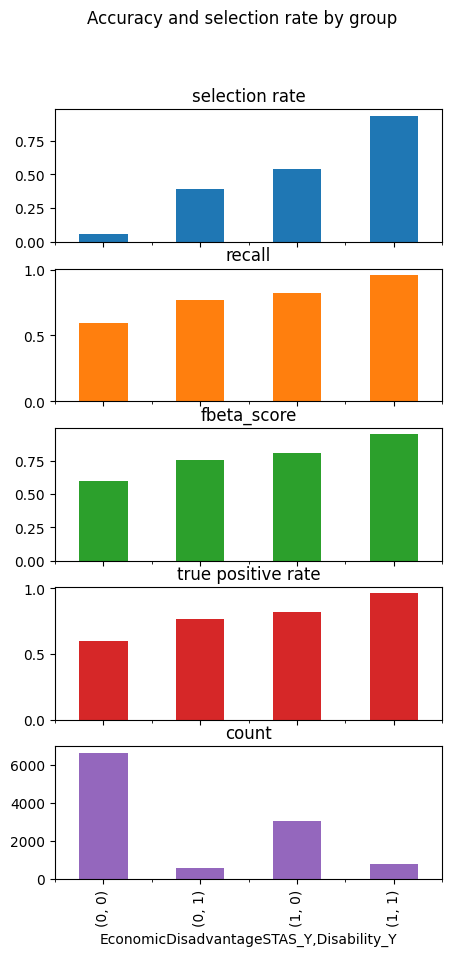

In [18]:
# We can start to assess the predictor’s fairness using the MetricFrame:
metric_frame = MetricFrame(
    metrics=fairness_metrics,
    sensitive_features=sensitive_features_test,
    y_true=y_test,
    y_pred=unmitigated_predictor.predict(X_test),
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[len(fairness_metrics.keys()), 1],
    legend=False,
    figsize=[5, len(fairness_metrics.keys()) * 2],
    title="Accuracy and selection rate by group",
)
print(metric_frame.overall)
metric_frame.by_group

In [19]:
fairness_grid_size = 500
# train additional models to attempt to migiate fairness issues
sweep = GridSearch(model,
                   constraints=DemographicParity(),
                   grid_size=fairness_grid_size)

# Fairlearns provide fit() and predict() methods, so they behave in a similar manner to other ML packages in Python. 
# We do however have to specify two extra arguments to fit() - the column of protected attribute labels, and also the number of predictors to generate in our sweep.
#After fit() completes, we extract the full set of predictors from the GridSearch object.

sweep.fit(X_train_prep, y_train_prep,
          sensitive_features=sensitive_features_train_prep)

predictors = sweep.predictors_



In [20]:
# We could plot performance and fairness metrics of these predictors now. 
# However, the plot would be somewhat confusing due to the large number of models. 
# In this case, we are going to remove the predictors which are dominated in 
# the error-disparity space by others from the sweep 
# (note that the disparity will only be calculated for the sensitive feature; 
# other potentially sensitive features will not be mitigated). An importance disclaimer: 
# in general, one might not want to do this, without other considerations 
# beyond the strict optimization of error and disparity (of the given sensitive feature).

# for illustration purpose only, we can set the error metric to overweigh recall rate
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)
    
    error = ErrorRate(costs={"fn": 1, "fp": 1./F_SCORE_BETA})  # similar to inverse of f-beta score
    error.load_data(X_train_prep, pd.Series(y_train_prep), sensitive_features=sensitive_features_train_prep)
    disparity = DemographicParity()
    disparity.load_data(X_train_prep, pd.Series(y_train_prep), sensitive_features=sensitive_features_train_prep)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

    
all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    accuracy_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= accuracy_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)


No matplotlib.Axes object was provided to draw on, so we create a new one


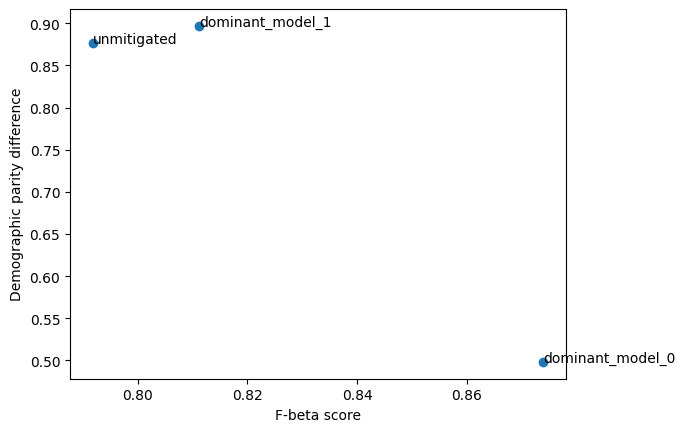

In [21]:
# Finally, we can evaluate the dominant models along with the unmitigated model.
predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for model_idx in range(len(non_dominated)):
    key = f"dominant_model_{model_idx}"
    predictions[key] = non_dominated[model_idx].predict(X_test)


plot_model_comparison(
    x_axis_metric=partial(fbeta_score, beta=F_SCORE_BETA, zero_division=0),
    y_axis_metric=demographic_parity_difference, 
    y_true=y_test,
    y_preds=predictions,
    sensitive_features=sensitive_features_test,
    axis_labels=("F-beta score", "Demographic parity difference"),
    point_labels=True,
    show_plot=True)

In [22]:

# upload dominant_model_0 for improvement in both demographic parity difference and F-beta scores 
model_idx = 0
with mlflow.start_run() as run:
    artifact_name = f"ProxyNomination{model_label}Mitigated"
    mlflow.sklearn.log_model(sk_model=non_dominated[model_idx], artifact_path=artifact_name)
    model_uri = f"runs:/{run.info.run_id}/{artifact_name}"
    mlflow.register_model(model_uri=model_uri, name=artifact_name)
 

Registered model 'ProxyNominationRFMitigated' already exists. Creating a new version of this model...
2023/03/10 16:36:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ProxyNominationRFMitigated, version 19
Created version '19' of model 'ProxyNominationRFMitigated'.


## Reliability of feature importance
**Transparency Principle** is about how we may understand the way the model arrives at a particular prediction for each student. It also gives rise to feature importance for me to understand on an aggregate level what features are considered important to the final prediction. Nevertheless, it is not sufficient due to several weaknesses of explanation algorithms. Given a data point from a dataset $x \sim D$, a prediction model $f$, a local explanation that is accurate with respect to its prediction $g(f, x) = f(x)$ may:    
- generate different feature importance by ranking and magnitude if we use a different prediction model $f$ (e.g. LogisticRegression vs RandomForestClassifier);  
- generate different feature importance if the explanation algorithm $g$ is different (e.g. KernelSHAP, LIME, TreeSHAP);
- generate different feature importance if the underlying dataset experiences distributional drift - a similar weakness in predictive tasks; and 
- be simultaneously be faithful or "correct" with respect to their prediction or explanation algorithms.

It is helpful to measure the degree of agreement by cosine similiarity between explanations or feature importance as demonstrated above, yet it is not clear which explanation gives the "best" answer. This is a known weakness of existing explanation algorithms, that it may not be friendly to human understanding and as such, they may not be reliable.

One possible way to increase reliability of explanations in terms of feature importance is introduce causal inference into interpretability. This is a way to support **Reliability and Safety Principle** in RAI best practice. 

Below we demonstrated how to make use of **Double Machine Learning** in **econml** to make the explanations more reliable and robust. Specifically, we measure 
1. how many of the features with top importance (by magnitude) have causal effects (by statistical significance);
2. how correlated are the magnitudes of feature importance and z-stat of the causal effects.    

It is important to note that this approach is sound to the extent that confounders are (nearly) all observed in the dataset. 

In [90]:
from econml.solutions.causal_analysis import CausalAnalysis

X_train, X_test, y_train, y_test = train_test_split(df[FEATURE_NAMES], df[PROXY_NOMINATION_TARGET], test_size=0.2, random_state=SEED)
treatment_features = FEATURE_NAMES
ca = CausalAnalysis(treatment_features,
                    categorical=[],
                    nuisance_models='automl',
                    heterogeneity_model='forest',
                    verbose=0,
                    classification=True,
                    random_state=SEED)
ca.fit(X_train, y_train)
gc = ca.global_causal_effect()

In [85]:
fi = individual_feature_importance.unstack(-1).mean(1).droplevel([0, 2], axis=0)
top_k_list = list(np.linspace(0.1, 1, 10))
sorted_fi = fi.sort_values()
zstat = gc.zstat
metrics = ['perc', 'ss', 'ss_perc', 'pearson', 'spearman', 'kendall']
corr_stat = {}
for top_k in top_k_list:
    if isinstance(top_k, float):
        top_k = int(top_k * sorted_fi.shape[0]) 
    top_fi = sorted_fi.tail(top_k)
    top_fi_sig = top_fi.reindex(zstat[zstat.abs()>2].index).dropna()
    pearson = top_fi.corr(zstat)
    spearman = top_fi.corr(zstat, method='spearman')
    kendall = top_fi.corr(zstat, method='kendall')
    corr_stat[top_k] = (top_k/fi.shape[0], top_fi_sig.shape[0], top_fi_sig.shape[0]/top_fi.shape[0], pearson, spearman, kendall)
corr_stat = pd.DataFrame(corr_stat, index=metrics).T

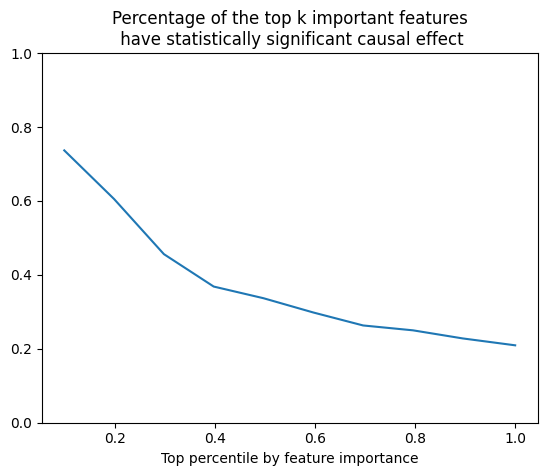

In [86]:

corr_stat.set_index('perc')['ss_perc'].plot(title='Percentage of the top k important features\n have statistically significant causal effect', ylim=(0, 1), xlabel='Top percentile by feature importance')

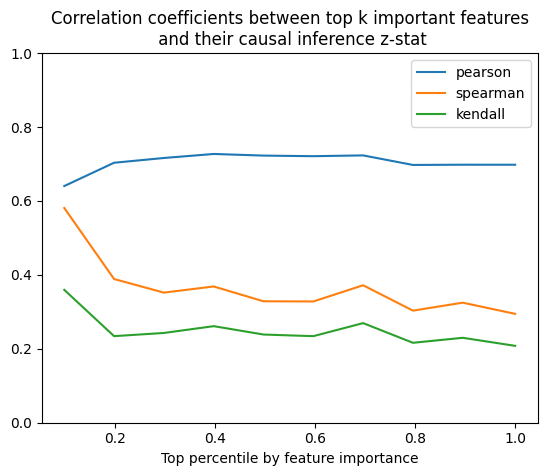

In [87]:

corr_stat.set_index('perc')[metrics[-3:]].plot(title='Correlation coefficients between top k important features\n and their causal inference z-stat', ylim=(0, 1), xlabel='Top percentile by feature importance')